In [1]:
import numpy as np
import random as rm
import seaborn as sns
from tqdm import trange

from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import math
import pandas as pd


/tmp/ipykernel_8341/1490183014.py:1: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



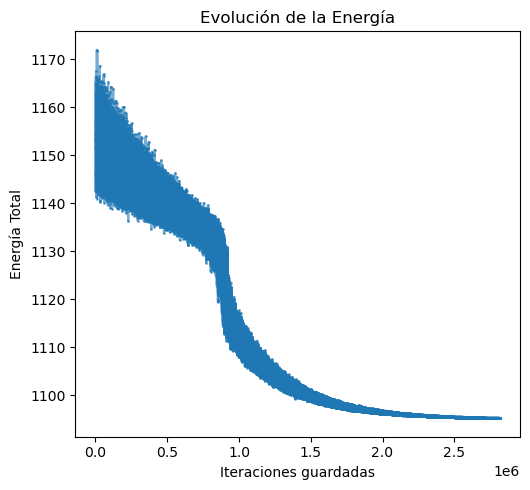

Text(0, 0.5, 'Energía Total')

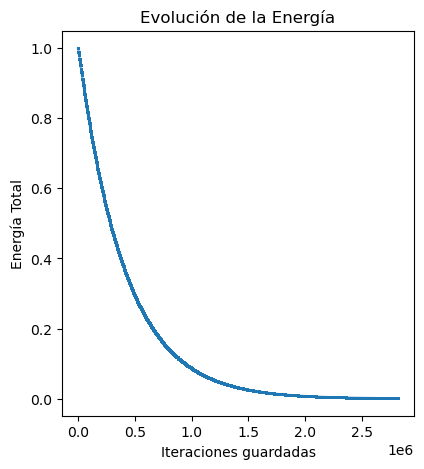

In [52]:

df_energy = pd.read_csv('energy.out', delim_whitespace=True, names=['step', 'E', 'T'])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df_energy['E'], marker='o', markersize=1, alpha=0.6)
plt.title("Evolución de la Energía")
plt.xlabel("Iteraciones guardadas")
plt.ylabel("Energía Total")


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(df_energy['T'], marker='o', markersize=1, alpha=0.6)
plt.title("Evolución de la Energía")
plt.xlabel("Iteraciones guardadas")
plt.ylabel("Energía Total")


Text(0, 0.5, 'E')

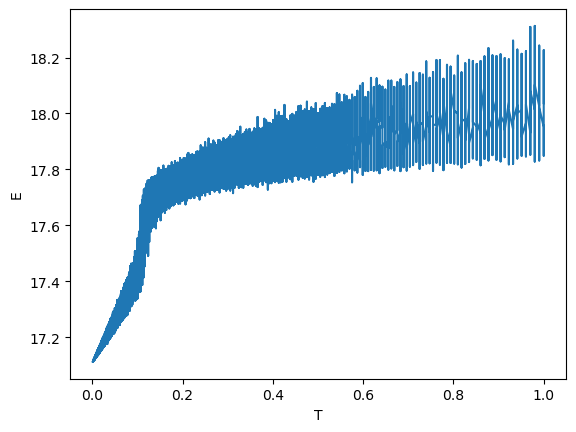

In [55]:
plt.plot()
plt.plot(df_energy['T'], df_energy['E']/64, markersize=1, alpha=1)
plt.xlabel("T")
plt.ylabel("E")

In [28]:
def read_xyz(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    trajectory = []
    step = 0
    total_lines = len(lines)
    
    while step < total_lines:
        try:
            # Línea 1: Número de átomos
            num_atoms = int(lines[step].strip())
            # Línea 2: Comentario (nos lo saltamos)
            
            # Líneas siguientes: Coordenadas
            # Empezamos en step + 2
            atom_lines = lines[step + 2 : step + 2 + num_atoms]
            
            coords = []
            for line in atom_lines:
                parts = line.split()
                # parts[0] es el símbolo, parts[1:4] son x, y, z
                coords.append([float(parts[1]), float(parts[2]), float(parts[3])])
            
            trajectory.append(np.array(coords))
            
            # Avanzar al siguiente bloque
            step += num_atoms + 2
            
        except (ValueError, IndexError):
            break
            
    return trajectory

# Cargar trayectoria
positions = read_xyz('positions.xyz')
print(f"Se cargaron {len(positions)} frames.")

Se cargaron 1 frames.


In [30]:

# @title
x = positions[0][:, 0]
y = positions[0][:, 1]
z = positions[0][:, 2]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=10,
                opacity=0.6
            )
        )
    ]
)


# # Special points (example: indices you want to highlight)
# highlight_idx = [0, 4, 7, 9, 10, 13, 14, 21, 26]

# fig.add_trace(
#     go.Scatter3d(
#         x=positions[highlight_idx, 0],
#         y=positions[highlight_idx, 1],
#         z=positions[highlight_idx, 2],
#         mode='markers',
#         marker=dict(size=14, color='red'),
#         name='Highlighted'
#     )
# )

fig.update_layout(
    scene=dict(
        # xaxis=dict(range=[-L/2, L/2]),
        # yaxis=dict(range=[-L/2, L/2]),
        # zaxis=dict(range=[-L/2, L/2]),
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()
fig.write_html("wigner_crystal_bcc_64_particles.html")


# structure factor taking into account pbc


In [ ]:
import numpy as np
import plotly.graph_objects as go
from itertools import combinations

pos = positions[0]
x, y, z = pos[:, 0], pos[:, 1], pos[:, 2]

# --- distance cutoff (adjust this!) ---
cutoff = 1.1 * np.min(
    np.linalg.norm(pos[1:] - pos[0], axis=1)
)

# --- build edge lists ---
Xe, Ye, Ze = [], [], []

for i, j in combinations(range(len(pos)), 2):
    d = np.linalg.norm(pos[i] - pos[j])
    if d < cutoff:
        Xe += [pos[i, 0], pos[j, 0], None]
        Ye += [pos[i, 1], pos[j, 1], None]
        Ze += [pos[i, 2], pos[j, 2], None]


fig = go.Figure()

# --- edges ---
fig.add_trace(
    go.Scatter3d(
        x=Xe, y=Ye, z=Ze,
        mode='lines',
        line=dict(color='black', width=2),
        name='Edges'
    )
)

# --- particles ---
fig.add_trace(
    go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=8, color='royalblue'),
        name='Particles'
    )
)


In [40]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

N = 64
density = 1.0
L = (N / density)**(1/3)

df = pd.read_csv('positions.xyz', delim_whitespace=True, names=['Elem', 'x', 'y', 'z'], header=None)
positions = df[['x', 'y', 'z']].values
x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

verts = np.array([
    [-L/2, -L/2, -L/2],
    [ L/2, -L/2, -L/2],
    [ L/2,  L/2, -L/2],
    [-L/2,  L/2, -L/2],
    [-L/2, -L/2,  L/2],
    [ L/2, -L/2,  L/2],
    [ L/2,  L/2,  L/2],
    [-L/2,  L/2,  L/2],
])

edges = [
    (0,1),(1,2),(2,3),(3,0),
    (4,5),(5,6),(6,7),(7,4),
    (0,4),(1,5),(2,6),(3,7)
]

Xe, Ye, Ze = [], [], []

for i, j in edges:
    Xe += [verts[i,0], verts[j,0], None]
    Ye += [verts[i,1], verts[j,1], None]
    Ze += [verts[i,2], verts[j,2], None]

fig = go.Figure()

fig.add_trace(go.Scatter3d(x=Xe, y=Ye, z=Ze, mode='lines', line=dict(color='black', width=4)))
fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=8, color='royalblue')))

fig.update_layout(
    scene=dict(
        xaxis=dict(showgrid=False, zeroline=False, visible=False),
        yaxis=dict(showgrid=False, zeroline=False, visible=False),
        zaxis=dict(showgrid=False, zeroline=False, visible=False),
        aspectmode='cube'
    ),
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=0, r=0, b=0, t=0)
)

fig.show()
fig.write_html("wigner_crystal_bcc_edges.html")


/tmp/ipykernel_8341/924744212.py:9: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



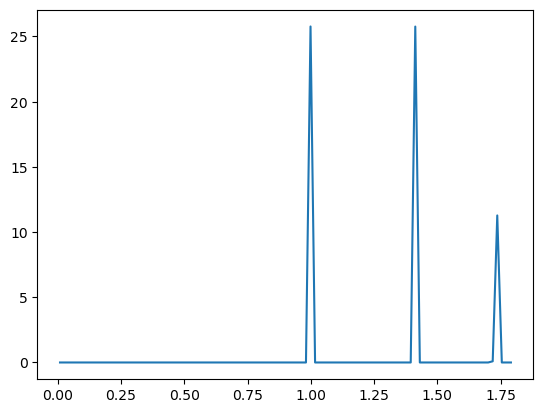

In [ ]:
import numpy as np

def calcular_gr_manual(positions, L, r_max, n_bins):
    N = len(positions)
    dr = r_max / n_bins
    hist = np.zeros(n_bins)

    delta = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    
  
    delta = delta - L * np.round(delta / L)
    
    dists = np.sqrt(np.sum(delta**2, axis=2))
    
    i_upper = np.triu_indices(N, k=1)
    dists_flat = dists[i_upper]
    
    counts, edges = np.histogram(dists_flat, bins=n_bins, range=(0, r_max))
    
   
    r_center = (edges[:-1] + edges[1:]) / 2
    vol_shell = 4 * np.pi * r_center**2 * dr
    rho = N / L**3
    
    g_r = (2 * counts) / (N * vol_shell * rho)
    
    return r_center, g_r

r_manual, gr_manual = calcular_gr_manual(atoms.get_positions(), L, r_max=1.8, n_bins=100)

plt.plot(r_manual, gr_manual,)
plt.show()